In [1]:
import warnings
warnings.filterwarnings("ignore")

# tree based classifier
import xgboost as xgb
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.ridge import RidgeClassifier 
from sklearn.gaussian_process.gpc import GaussianProcessClassifier

# ensemble classifiers
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier

# linear classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score, cross_validate

from sklearn.preprocessing import StandardScaler


In [2]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.metrics import sensitivity_specificity_support, geometric_mean_score, classification_report_imbalanced
from imblearn.pipeline import Pipeline, make_pipeline

In [3]:
import seaborn as sns

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
from scipy.stats import spearmanr, pearsonr

In [18]:
from collections import Counter
import os
import sys

### If u want to try it out for  yourself, all you need to do is clone the repo and specify the `base_dir` variable below

In [24]:
base_dir = "E:\\Btech project\\leaf_disease\\feature_files" # Specify your own directory root
binary_file = base_dir + r"\new_glcm(binary).csv"
multiclass_file = base_dir + r"\new_glcm(multiclass).csv"

In [22]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

In [23]:
b_df = pd.read_csv(binary_file)
m_df = pd.read_csv(multiclass_file)

In [26]:
def pipeline_prediction(X, y, model, sampler=None, plot_confusion_matrix=False, filename=None):
    
    pipe = Pipeline([('scaler', StandardScaler()), ('sampler', sampler), ('model', model)])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    
    print(f"Before sampling: {Counter(y_train)}") 

    pipe.fit(X_train, y_train)

    get_metrics(y_true=y_test, y_pred=pipe.predict(X_test), plot_confusion_matrix=plot_confusion_matrix, file_name=filename)
    
    # return pipeline for direct prediction, skipping the details
    # receive the piepline and can call `get_metrics()` normally
    return pipe
    

In [29]:
def get_metrics(y_true, y_pred, y_score=None, file_name=None, plot_confusion_matrix=False):
    
    print(f'Accuracy: {accuracy_score(y_true=y_true, y_pred=y_pred)}')
   
    print(classification_report_imbalanced(y_true=y_true, y_pred=y_pred))
    
    if y_score is not None:
        print(f"Roc-auc-score: {roc_auc_score(y_pred, y_score=y_score)}")
        plot_roc_curve(y_true=y_true, y_proba=y_score, n_classes=len(np.unique(y_true)))
    
    labels = ['True Neg','False Pos','False Neg','True Pos']
    
    if plot_confusion_matrix:
        if len(np.unique(y_true)) > 2:
            categories = ['Zero', 'One', 'Two']
        else:
            categories = ['Zero', 'One']

        cf_matrix = confusion_matrix(y_true, y_pred)
        make_confusion_matrix(cf_matrix, 
                              group_names=labels,
                              categories=categories, 
                              cmap='Blues', fig_name=file_name)


In [30]:
# Taken from: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          fig_name=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns_plot = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
    if fig_name:
        figure = sns_plot.get_figure()
        figure.savefig(fig_name)
        
        print(f"Saved: {fig_name}")

# *Binary Classification tests*

In [31]:
b_df.head()

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0100_Brown spot_10_binary.npy,64.003665,0.250995,0.999016,0.953311,0.988906,0
1,DSC_0100_Brown spot_11_binary.npy,73.536126,0.288377,0.998869,0.951997,0.987579,0
2,DSC_0100_Brown spot_12_binary.npy,58.556545,0.229634,0.999099,0.954353,0.989632,0
3,DSC_0100_Brown spot_13_binary.npy,59.918325,0.234974,0.999079,0.954955,0.989254,0
4,DSC_0100_Brown spot_14_binary.npy,61.280105,0.240314,0.999058,0.956024,0.988751,0


In [32]:
b_df.head()

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0100_Brown spot_10_binary.npy,64.003665,0.250995,0.999016,0.953311,0.988906,0
1,DSC_0100_Brown spot_11_binary.npy,73.536126,0.288377,0.998869,0.951997,0.987579,0
2,DSC_0100_Brown spot_12_binary.npy,58.556545,0.229634,0.999099,0.954353,0.989632,0
3,DSC_0100_Brown spot_13_binary.npy,59.918325,0.234974,0.999079,0.954955,0.989254,0
4,DSC_0100_Brown spot_14_binary.npy,61.280105,0.240314,0.999058,0.956024,0.988751,0


In [33]:
b_df = b_df.sample(frac=1).reset_index(drop=True)

In [34]:
b_df.head(20)

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0397_Bacterial leaf blight_28_binary.npy,16.045854,0.080738,0.995344,0.985769,0.988859,0
1,DSC_0392_Bacterial leaf blight_8_binary.npy,24.655884,0.119870,0.995009,0.986611,0.981922,0
2,DSC_0503_Leaf smut_77_binary.npy,47.656056,0.188184,0.998873,0.966921,0.988463,0
3,DSC_0301_Brown spot_10_binary.npy,14.952817,0.073955,0.995878,0.986961,0.988777,0
4,DSC_0392_Bacterial leaf blight_15_binary.npy,19.926495,0.093102,0.995899,0.987389,0.985171,0
5,DSC_0385_Bacterial leaf blight_72_binary.npy,4.564285,0.048259,0.994170,0.988630,0.990330,0
6,DSC_0335_Leaf smut_31_binary.npy,14.479869,0.071439,0.996626,0.986734,0.989376,0
7,DSC_0384_Bacterial leaf blight_70_binary.npy,2.141393,0.034745,0.994728,0.989556,0.991890,0
8,DSC_0372_Bacterial leaf blight_51_binary.npy,3.441429,0.045660,0.992873,0.991291,0.986653,1
9,DSC_0309_Leaf smut_64_binary.npy,9.876681,0.050581,0.996488,0.991648,0.988409,1


In [35]:
b_df['label'].value_counts()

0    6943
1    2481
Name: label, dtype: int64

In [36]:
X = b_df.iloc[:, 1:-1].values
y = b_df['label'].values

In [37]:
lr = LogisticRegression()
sampler = SMOTETomek()

res = pipeline_prediction(X, y, model=lr, sampler=sampler)

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6909967845659164
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.72      0.61      0.77      0.66      0.45      2291
          1       0.44      0.61      0.72      0.51      0.66      0.44       819

avg / total       0.73      0.69      0.64      0.70      0.66      0.44      3110



In [21]:
lr = LogisticRegression(class_weight='balanced')


Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6884244372990354
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.70      0.64      0.77      0.67      0.46      2291
          1       0.44      0.64      0.70      0.52      0.67      0.45       819

avg / total       0.74      0.69      0.66      0.70      0.67      0.45      3110



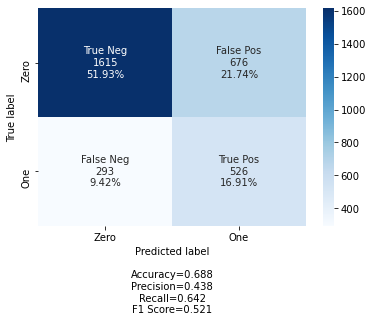

In [22]:
_ = pipeline_prediction(X, y, lr)


#### Note: I have used `.sample(frac=1)` to shuffle each Dataframe.

In [23]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 6943, 1: 2481})


In [24]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

In [25]:
print('Oversampled dataset shape %s' % Counter(y_res))`

Oversampled dataset shape Counter({0: 6943, 1: 6943})


#### `SMOTE + LogisticRegression(class_weight='balanced')` results the same as in `SMOTE + LogisticRegression()`   

In [26]:
?DecisionTreeClassifier

In [27]:
dt = DecisionTreeClassifier(criterion='entropy', splitter='best')

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6672025723472669
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.73      0.50      0.76      0.60      0.37      2291
          1       0.39      0.50      0.73      0.44      0.60      0.35       819

avg / total       0.69      0.67      0.56      0.68      0.60      0.37      3110



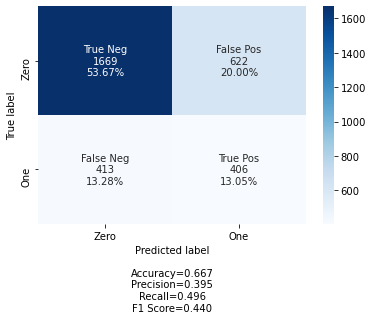

In [28]:
_ = pipeline_prediction(X, y, model=dt, sampler=SMOTETomek())

In [29]:
dt = DecisionTreeClassifier(criterion='entropy', splitter='best', class_weight='balanced')


Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6617363344051447
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.72      0.51      0.76      0.60      0.37      2291
          1       0.39      0.51      0.72      0.44      0.60      0.36       819

avg / total       0.69      0.66      0.56      0.67      0.60      0.37      3110



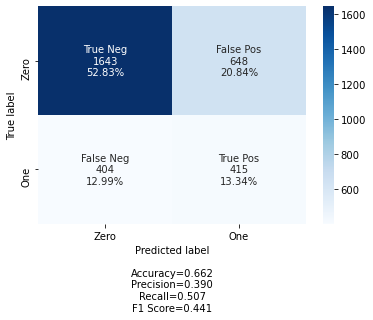

In [30]:
_ = pipeline_prediction(X, y, model=dt, sampler=SMOTETomek())

In [31]:
knn = KNeighborsClassifier(weights='distance')

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6578778135048231
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.68      0.60      0.74      0.64      0.41      2291
          1       0.40      0.60      0.68      0.48      0.64      0.40       819

avg / total       0.71      0.66      0.62      0.68      0.64      0.41      3110



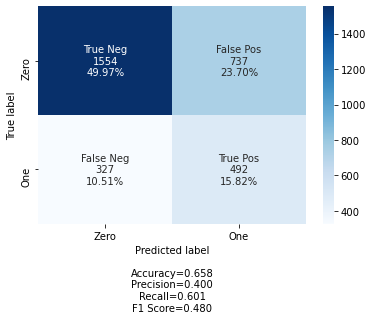

In [32]:
_ = pipeline_prediction(X, y, model=knn, sampler=SMOTE())

# Now let's try `Bagging`

In [33]:

dt_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, n_jobs=10)


Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.692604501607717
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.75      0.53      0.78      0.63      0.41      2291
          1       0.43      0.53      0.75      0.48      0.63      0.39       819

avg / total       0.72      0.69      0.59      0.70      0.63      0.40      3110



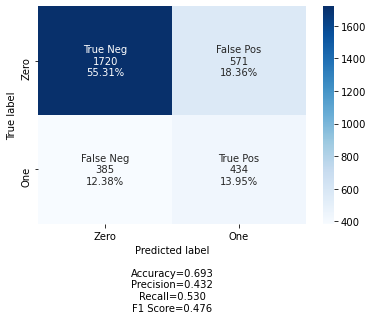

In [34]:
_ = pipeline_prediction(X, y, model=dt_bag, sampler=SMOTETomek())

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.7003215434083602
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.77      0.51      0.79      0.63      0.40      2291
          1       0.44      0.51      0.77      0.47      0.63      0.38       819

avg / total       0.72      0.70      0.58      0.71      0.63      0.40      3110

Saved: rf.jpg


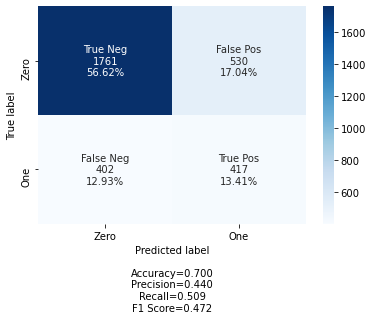

In [40]:
model = RandomForestClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler, plot_confusion_matrix=True, filename="rf.jpg")

## Boosting ⚡🔥

In [43]:
model = xgb.XGBClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6717041800643087
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.65      0.74      0.74      0.69      0.47      2291
          1       0.43      0.74      0.65      0.54      0.69      0.48       819

avg / total       0.76      0.67      0.71      0.69      0.69      0.48      3110



# *Multi-class Classification*

In [42]:
m_df.head()

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0100_Brown spot_34_multiclass.npy,84.081099,0.337665,0.998142,0.948118,0.986702,1
1,DSC_0100_Brown spot_35_multiclass.npy,53.901455,0.222576,0.998778,0.956402,0.989780,1
2,DSC_0100_Brown spot_43_multiclass.npy,71.474377,0.288838,0.998007,0.954366,0.987098,1
3,DSC_0100_Brown spot_45_multiclass.npy,22.443047,0.236387,0.985251,0.978301,0.981649,1
4,DSC_0100_Brown spot_46_multiclass.npy,39.486052,0.294555,0.986651,0.961464,0.983676,1


In [44]:
m_df.drop(m_df.columns[0], axis=1, inplace=True)

In [45]:
m_df.head()

,contrast,dissimilarity,homogeneity,correlation,energy,label
0,84.081099,0.337665,0.998142,0.948118,0.986702,1
1,53.901455,0.222576,0.998778,0.956402,0.989780,1
2,71.474377,0.288838,0.998007,0.954366,0.987098,1
3,22.443047,0.236387,0.985251,0.978301,0.981649,1
4,39.486052,0.294555,0.986651,0.961464,0.983676,1


In [46]:
m_df = m_df.sample(frac=1).reset_index(drop=True)

In [47]:
m_df.head(20)

,contrast,dissimilarity,homogeneity,correlation,energy,label
0,13.419678,0.134647,0.995231,0.892752,0.994146,1
1,6.767611,0.079239,0.992187,0.976408,0.987300,0
2,5.007644,0.076171,0.992333,0.969218,0.986707,2
3,12.886946,0.176405,0.978144,0.989219,0.968602,0
4,113.930644,0.769750,0.985757,0.848117,0.984275,2
5,7.257744,0.116339,0.988056,0.978692,0.983241,2
6,18.757963,0.112490,0.993744,0.986796,0.981766,0
7,81.652335,0.628856,0.972995,0.940896,0.964687,1
8,1.610800,0.035905,0.994920,0.986222,0.992840,0
9,16.829880,0.121184,0.992101,0.985272,0.984548,2


In [48]:
X = m_df.iloc[:, :-1]
y = m_df['label']

In [53]:
model = xgb.XGBClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.6324786324786325
                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.78      0.78      0.64      0.78      0.61       199
          1       0.65      0.65      0.84      0.65      0.74      0.53       251
          2       0.72      0.54      0.83      0.62      0.67      0.44       369

avg / total       0.65      0.63      0.82      0.63      0.72      0.51       819



In [51]:
model = ExtraTreesClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.6605616605616605
                   pre       rec       spe        f1       geo       iba       sup

          0       0.60      0.71      0.85      0.65      0.78      0.60       199
          1       0.68      0.64      0.87      0.66      0.74      0.54       251
          2       0.69      0.65      0.76      0.67      0.70      0.49       369

avg / total       0.66      0.66      0.82      0.66      0.73      0.53       819



Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.525030525030525
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.65      0.79      0.56      0.72      0.51       199
          1       0.51      0.30      0.87      0.38      0.51      0.25       251
          2       0.55      0.61      0.58      0.58      0.60      0.36       369

avg / total       0.52      0.53      0.72      0.51      0.60      0.36       819



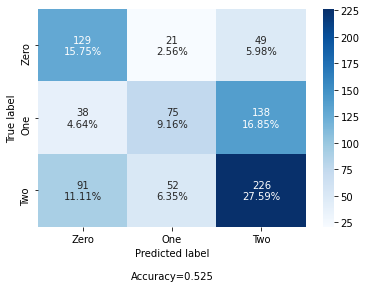

In [48]:
model = AdaBoostClassifier()
sampler = ADASYN()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.6581196581196581
                   pre       rec       spe        f1       geo       iba       sup

          0       0.59      0.72      0.84      0.65      0.78      0.60       199
          1       0.68      0.69      0.86      0.68      0.77      0.58       251
          2       0.69      0.61      0.78      0.65      0.69      0.46       369

avg / total       0.66      0.66      0.82      0.66      0.73      0.53       819

Saved: rf_mul.jpg


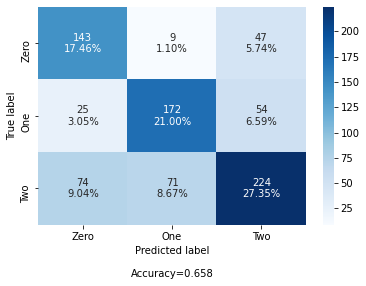

In [54]:
model = RandomForestClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler, plot_confusion_matrix=True, filename="rf_mul.jpg")